# Block-sparse Estimation of Large Structured Precision Matrices

The goal of this notebook is to experiment with the estimation of parametrized precision matrices with a block sparse prior structure.

Our prior is imposing a block-diagonal (and maybe block-triagonal) structure with constant values for diagonal and off-diagonal entries in each block.

The end-goal is to find a tractable estimate the Fisher Information Matrix of a deep feed-forward networks by making the assumption that gradients of the log-likelihood of the model sampled from the model predictive probability distribution will be approximately distributed with a multivariate Gaussian matrix whose precision matrix follows our prior structure: the blocks of the precision matrix prior corresponds to the set of trainable model parameters of a given layer in the feed-forward net.

Being able to estimate the inverse FIM of large models can be useful for improving the conditioning of the optimization problem when estimating the model parameters from the data. More generally it's useful to evaluate information theoretic measures of the capacity of the model or compute distances between different parametrization of the same model and so on.

Contrary to the [K-FAC](https://arxiv.org/abs/1503.05671) parametrization, our proposed parametrization of the inverse FIM uses far fewer parameters (because we impose constant values of the entries of the inverse FIM in a given block). And furthermore we plan to use a MLE estimate of the precision matrix given a recent history of model gradients.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from time import time

/home/ogrisel/.virtualenvs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
session = tf.Session()

In [3]:
def make_block_linear_operator(block_sizes, variable=tf.Variable,
                               diag_init=0., lowrank_init=0.1):
    dim = sum(block_sizes)
    n_blocks = len(block_sizes)
    psd_args = dict(
        is_non_singular=True,
        is_self_adjoint=True,
        is_positive_definite=True,
    )
    diagonal = tf.zeros([dim])
    if hasattr(diag_init, 'shape') or hasattr(diag_init, '__len__'):
        diag_variables = variable(diag_init)
    else:
        diag_variables = variable(diag_init * tf.ones(n_blocks))
    if hasattr(lowrank_init, 'shape') or hasattr(lowrank_init, '__len__'):
        lowrank_variables = variable(lowrank_init)
    else:
        lowrank_variables = variable(lowrank_init * tf.ones(n_blocks))

    offset = 0
    tic = time()
    for i, block_size in enumerate(block_sizes):
        pad_before = offset
        pad_after = dim - (offset + block_size)
        diagonal += tf.pad(tf.exp(diag_variables[i:i+1]) * tf.ones([block_size]),
                           [[pad_before, pad_after]])
        offset += block_size
    linop = tf.linalg.LinearOperatorDiag(diagonal, **psd_args)
    print(f"diagonal operator built in {time() - tic:.3f}s")

    offset = 0
    for i, block_size in enumerate(block_sizes):
        tic = time()
        pad_before = offset
        pad_after = dim - (offset + block_size)
        u = tf.pad(lowrank_variables[i:i+1] * tf.ones([block_size, 1]),
                   [[pad_before, pad_after], [0, 0]])

        # Recursively chain the the LR updates operators: this is the
        # expensive step as it precomputes the solution of A.X = U where
        # A is the previous base operator.
        linop = tf.linalg.LinearOperatorLowRankUpdate(linop, u=u, **psd_args)
        offset += block_size
        print(f"lowrank update operator built in {time() - tic:.3f}s")
    return linop, [diag_variables, lowrank_variables] 

In [4]:
K, variables = make_block_linear_operator(
    [3, 5, 5, 1], diag_init=0., lowrank_init=0.1)

session.run(tf.global_variables_initializer())
%time session.run(K.log_abs_determinant())

diagonal operator built in 0.023s
lowrank update operator built in 0.008s
lowrank update operator built in 0.013s
lowrank update operator built in 0.021s
lowrank update operator built in 0.038s
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 49.4 ms


0.13708931

In [5]:
%time session.run(tf.gradients(K.log_abs_determinant(), variables))

CPU times: user 812 ms, sys: 20 ms, total: 832 ms
Wall time: 828 ms


[array([2.9708738, 4.952381 , 4.952381 , 0.990099 ], dtype=float32),
 array([0.58252436, 0.952381  , 0.952381  , 0.19801979], dtype=float32)]

In [6]:
# val_and_grad_fn = tfe.value_and_gradients_function(lambda K: K.log_abs_determinant())
# val_and_grad_fn(K)

In [7]:
K_tensor = K.to_dense()

By default, only the elements of the diagonal are non-zero (ones actually), this is the identity matrix:

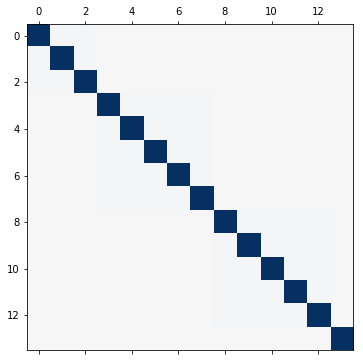

In [8]:
def matshow(a, cmap=plt.cm.RdBu, figsize=(6, 6)):
    vmax = np.abs(a).max()
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(a, vmin=-vmax, vmax=vmax, cmap=cmap)

matshow(session.run(K_tensor))

Reassigning different parameter values makes the block structure visible:

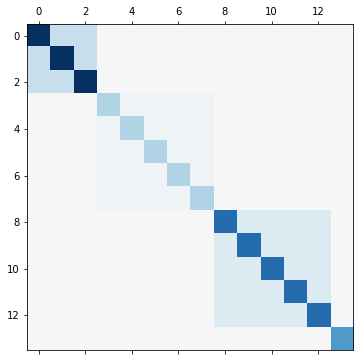

In [9]:
session.run(tf.global_variables_initializer())
diag_variables, offdiag_variables = variables
session.run(diag_variables.assign([1, -.1, 0.8, 0]))
session.run(offdiag_variables.assign([0.9, 0.4, 0.7, 1]))
matshow(session.run(K.to_dense()))

In [10]:
np.mean(session.run(K.to_dense()) == 0)

0.6938775510204082

`tf.linalg.expm` would preserve the prior sparse block structure and would enforce full-rank however support for linear opertor does not seem to be implemented yet, it only works on the memory-untractable full-matrix materialization of the precision matrix:

47262407000000.0

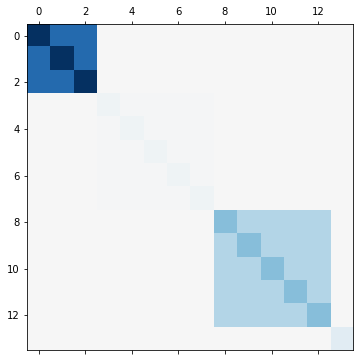

In [11]:
K_expm = tf.linalg.expm(K_tensor)
K_expm_value, K_expm_det = session.run([K_expm, tf.linalg.det(K_expm)])
matshow(K_expm_value)
K_expm_det

Let's have a look a the inverse of the precision matrix (covariance matrix):

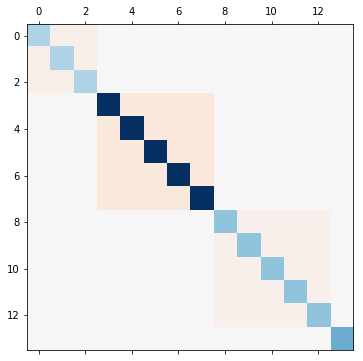

In [12]:
matshow(session.run(tf.linalg.inv(K_tensor)));

The sparsity pattern is actually preserved but now we have negative values.

0.6938775510204082

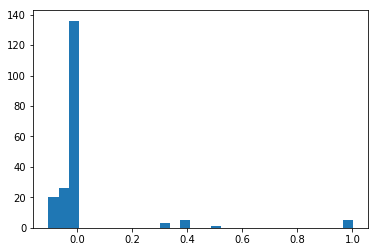

In [13]:
K_inv = session.run(tf.linalg.inv(K_tensor))
plt.hist(K_inv.ravel(), bins=30)
np.mean(K_inv == 0)

Let's try with a more realistic size, this time we won't try to materialize it as a tensor:

In [14]:
%time big_K, big_variables = make_block_linear_operator([4096] * 8)

diagonal operator built in 0.039s
lowrank update operator built in 0.008s
lowrank update operator built in 0.012s
lowrank update operator built in 0.021s
lowrank update operator built in 0.038s
lowrank update operator built in 0.077s
lowrank update operator built in 0.154s
lowrank update operator built in 0.350s
lowrank update operator built in 0.735s
CPU times: user 1.58 s, sys: 136 ms, total: 1.72 s
Wall time: 1.55 s


In [15]:
# %load_ext line_profiler

In [16]:
# %lprun -f tf.linalg.LinearOperatorLowRankUpdate.__init__ make_block_linear_operator([4096] * 10)

In [17]:
big_K.shape

TensorShape([Dimension(32768), Dimension(32768)])

In [18]:
np.product(big_K.shape).value / 1e9

1.073741824

Our parametrization of a this very large precision matrix has only a handful of trainable parameters:

In [19]:
sum(np.prod(v.shape).value for v in big_variables)

16

In [20]:
%time big_det = big_K.log_abs_determinant()

CPU times: user 64 ms, sys: 4 ms, total: 68 ms
Wall time: 66.3 ms


In [21]:
session.run(tf.global_variables_initializer())
%time session.run(big_det)

CPU times: user 372 ms, sys: 4 ms, total: 376 ms
Wall time: 347 ms


29.893726

## Maximum Likelihood Estimation of K

diagonal operator built in 0.019s
lowrank update operator built in 0.010s
lowrank update operator built in 0.015s
lowrank update operator built in 0.142s
lowrank update operator built in 0.047s


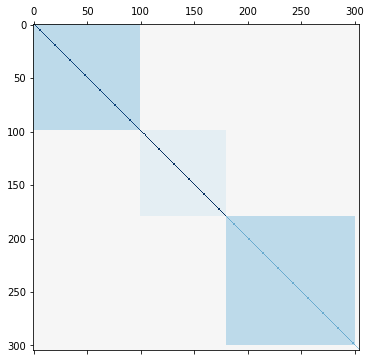

In [22]:
block_sizes = [100, 80, 120, 5]
# ground truth distribution parameters:
K_gt, variables_gt = make_block_linear_operator(
    block_sizes,
    diag_init=[0.5, 0.8, -0.5, 0],
    lowrank_init=[0.8, 0.5, 0.8, 0]
)

session.run(tf.global_variables_initializer())
K_gt_tensor = session.run(K_gt.to_dense())
matshow(K_gt_tensor)

In [23]:
C_gt = tf.linalg.inv(K_gt_tensor)
# matshow(session.run(C_gt)

In [24]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance


model_gt = MultivariateNormalFullCovariance(loc=tf.zeros([C_gt.shape[0]], dtype=np.float32),
                                            covariance_matrix=C_gt)
data_train = session.run(model_gt.sample(50))
data_train = tf.constant(data_train)

Check a naive empirical precision matrix estimate from the training data (no prior):

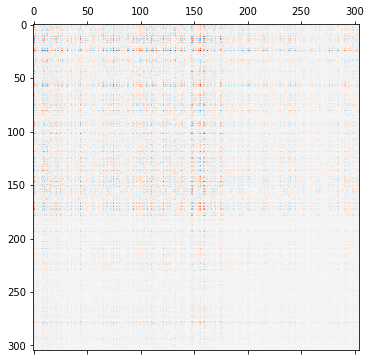

In [25]:
matshow(session.run(tf.linalg.inv(tf.matmul(tf.transpose(data_train), data_train))));

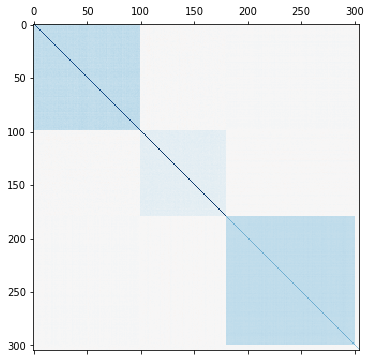

In [26]:
data_test = session.run(model_gt.sample(10000))
data_test = tf.constant(data_test)
matshow(session.run(tf.linalg.inv(tf.matmul(tf.transpose(data_test), data_test))));

Make a new estimator with the default init:

diagonal operator built in 0.026s
lowrank update operator built in 0.013s
lowrank update operator built in 0.020s
lowrank update operator built in 0.033s
lowrank update operator built in 0.046s


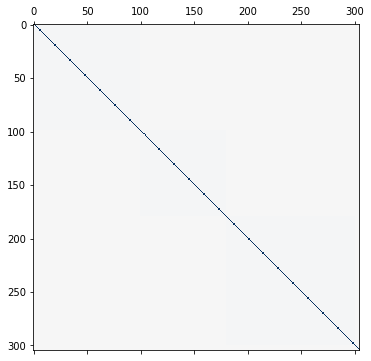

In [27]:
K, variables = make_block_linear_operator(block_sizes)
session.run(tf.global_variables_initializer())
matshow(session.run(K.to_dense()))

In [28]:
def loss(K, data):
    return tf.reduce_mean(0.5 * (
        - K.log_abs_determinant()
        + tf.reduce_sum(tf.transpose(data) * K.matmul(tf.transpose(data)), axis=0)
        + K.shape[0].value * np.log(2 * np.pi)
    ))

In [29]:
session.run(loss(K_gt, data_train))

400.73163

In [30]:
session.run(loss(K_gt, data_test))

400.18646

In [31]:
train_loss = loss(K, data_train)
session.run(train_loss)

428.83765

In [32]:
test_loss = loss(K, data_test)
session.run(test_loss)

427.59415

In [33]:
session.run(variables)

[array([0., 0., 0., 0.], dtype=float32),
 array([0.1, 0.1, 0.1, 0.1], dtype=float32)]

In [34]:
grads_op = tf.gradients(loss(K, data_train), variables)
grads_value = session.run(grads_op)
grads_value

[array([-19.760296  , -22.064772  ,  39.937897  ,  -0.28240305],
       dtype=float32),
 array([-4.8759127 , -4.0111413 , -5.321869  ,  0.01078427], dtype=float32)]

In [35]:
diag_grad_norm, low_rank_grad_norm = [np.linalg.norm(gv) for gv in grads_value]

In [36]:
diag_grad_norm

49.723625

In [37]:
low_rank_grad_norm

8.257492

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(train_loss, var_list=variables)
session.run(tf.global_variables_initializer())

history = {
    'train_loss': [session.run(train_loss)],
    'test_loss': [session.run(test_loss)],
    'diag_grad_norm': [diag_grad_norm],
    'low_rank_grad_norm': [low_rank_grad_norm],
    'step': [0],
}
for i in range(250):
    _, train_loss_value, grads_value = session.run([train_op, train_loss, grads_op])
    if (i + 1) % 10 == 0:
        test_loss_value = session.run(test_loss)
        diag_grad_norm, low_rank_grad_norm = [np.linalg.norm(gv) for gv in grads_value]
        print(f"[{i + 1:03d}] train loss: {train_loss_value:.5f}, test loss: {test_loss_value:.5f}, "
              f"diag grad: {diag_grad_norm:.5f}, lowrank grad: {low_rank_grad_norm:.5f}")
        history['train_loss'].append(train_loss_value)
        history['test_loss'].append(test_loss_value)
        history['diag_grad_norm'].append(diag_grad_norm)
        history['low_rank_grad_norm'].append(low_rank_grad_norm)
        history['step'].append(i + 1)
        
        # TODO: snapshot parameters for model with best validation set params
        # Early stop when no more progress on training set (just to
        # keep convergence plots interesting and highlight overfitting).
        
        # TODO: Polyak-Rupert averaging of the estimator variables + add small noise
        # to training data to make Polyak-Rupert averaging more interesting.

[010] train loss: 420.95090, test loss: 419.11646, diag grad: 41.10348, lowrank grad: 6.35611
[020] train loss: 414.16882, test loss: 412.68576, diag grad: 32.54999, lowrank grad: 4.34101
[030] train loss: 409.29865, test loss: 408.09030, diag grad: 25.23692, lowrank grad: 3.09239
[040] train loss: 405.99387, test loss: 404.99585, diag grad: 19.20379, lowrank grad: 2.32366
[050] train loss: 403.86658, test loss: 403.03152, diag grad: 14.40304, lowrank grad: 1.82829
[060] train loss: 402.55258, test loss: 401.83765, diag grad: 10.70382, lowrank grad: 1.48415
[070] train loss: 401.76105, test loss: 401.12689, diag grad: 7.89306, lowrank grad: 1.22460
[080] train loss: 401.29022, test loss: 400.71005, diag grad: 5.73113, lowrank grad: 1.01706
[090] train loss: 401.01520, test loss: 400.47305, diag grad: 4.03576, lowrank grad: 0.84652
[100] train loss: 400.86017, test loss: 400.34402, diag grad: 2.71071, lowrank grad: 0.70505
[110] train loss: 400.77692, test loss: 400.27777, diag grad: 1.

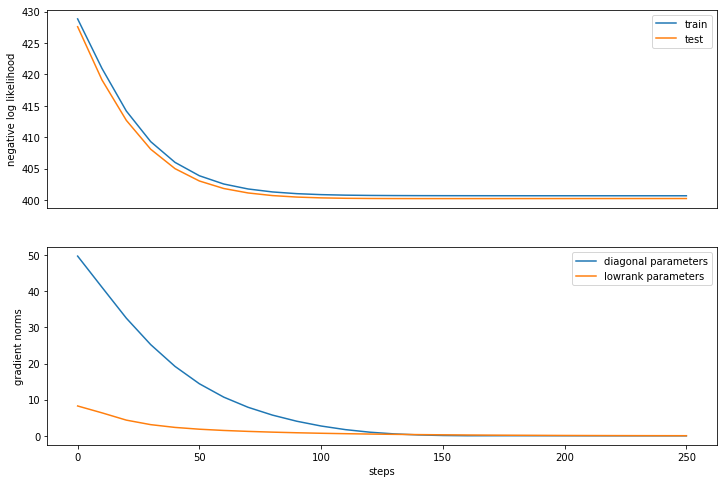

In [39]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12, 8))
x = history['step']
ax0.plot(x, history['train_loss'], label='train')
ax0.plot(x, history['test_loss'], label='test')
ax0.set_ylabel('negative log likelihood')
ax0.set_xticks([])
ax0.legend()

ax1.plot(x, history['diag_grad_norm'], label='diagonal parameters')
ax1.plot(x, history['low_rank_grad_norm'], label='lowrank parameters')
ax1.set_ylabel('gradient norms')
ax1.set_xlabel('steps')
ax1.legend();

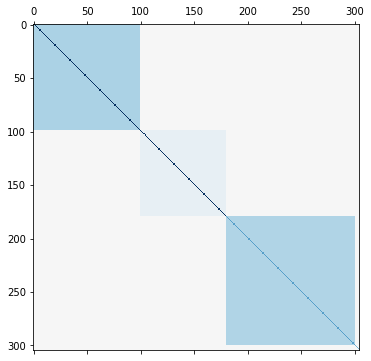

In [40]:
matshow(session.run(K.to_dense()))

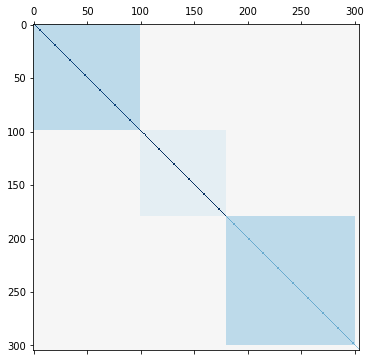

In [41]:
matshow(session.run(K_gt.to_dense()))

## Part two: backups

In [42]:
# try:
#     tfe.enable_eager_execution()
# except ValueError:
#     # Hide the annoying lack of idem-potency.
#     pass

In [43]:
block_boundaries = [0, 5, 8, 10]
# block_boundaries = [0]
# block_boundaries.append(block_boundaries[-1] + 784 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)



def outer(v):
    return tf.matmul(tf.reshape(v, (-1, 1)),
                     tf.reshape(v, (1, -1)))


def parametrized_precision(block_boundaries):
    variables = []
    n_params = block_boundaries[-1]
    K = tf.zeros(shape=(n_params, n_params))
    for i, j in zip(block_boundaries, block_boundaries[1:]):
        # Diagonal for the current block
        diag_mask_i = np.zeros(n_params, dtype=np.float32)
        diag_mask_i[i:j] = 1
        diag_mask_i = tf.constant(diag_mask_i)
        K_i_var = tf.Variable(0.5, dtype=np.float32)
        K_i = tf.diag(tf.exp(K_i_var) * diag_mask_i)
        variables.append(K_i_var)
        K += K_i
        
        # Rank-one for the current parameter block
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tf.Variable(1, dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    for i, j in zip(block_boundaries, block_boundaries[2:]):
        # Rank-one for consecutive blocks interactions
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tf.Variable(1., dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    return K, variables

K2, variables = parametrized_precision(block_boundaries)

In [44]:
session.run(tf.global_variables_initializer())
K2 = session.run(K2)

8

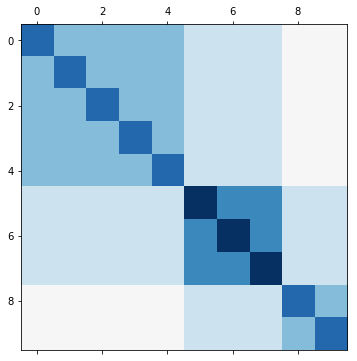

In [45]:
matshow(K2)
len(variables)

In [46]:
np.linalg.det(K2)

18083.242

array([ 1.6487198,  1.6487209,  1.648721 ,  1.6487212,  1.6487212,
        1.6487212,  1.6487213,  4.268642 ,  8.341459 , 15.3360615],
      dtype=float32)

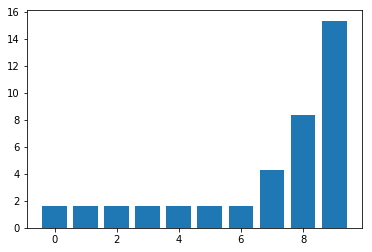

In [47]:
eigvals = session.run(tf.linalg.eigh(K2)[0])
plt.bar(np.arange(K2.shape[0]), eigvals)
eigvals

In [48]:
C = session.run(tf.linalg.inv(K2))
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(C)

In [49]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance


model = MultivariateNormalFullCovariance(loc=tf.zeros([C.shape[0]], dtype=np.float32), covariance_matrix=C)

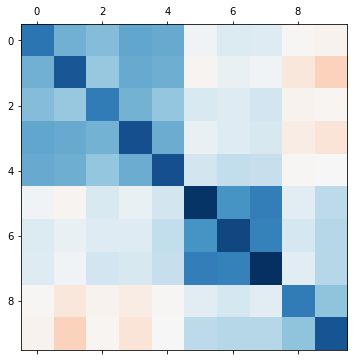

In [50]:
data = session.run(model.sample(100))
matshow(session.run(tf.linalg.inv(tf.matmul(tf.transpose(data), data))));

In [51]:
# from sklearn.covariance import graph_lasso

# gl = graph_lasso(np.asarray(tf.matmul(tf.transpose(data), data)), 1)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(gl[1])

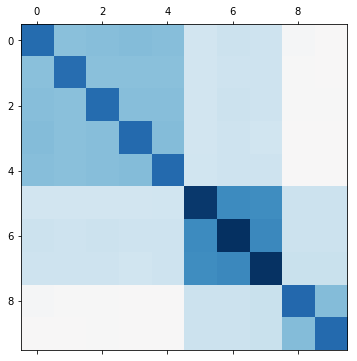

In [52]:
data_large = session.run(model.sample(10000))
matshow(session.run(tf.linalg.inv(tf.matmul(tf.transpose(data_large), data_large))));

## Ill-conditionned deep linear models

In [53]:
from numpy.linalg import qr


def unitary(rng, n, m, dtype=np.float32):
    if n <= m:
        return qr(rng.randn(m, n).astype(dtype), mode='reduced')[0].T
    else:
        return qr(rng.randn(n, m).astype(dtype), mode='reduced')[0]


def ill_cond(rng, n, m, cond_number=100, dtype=np.float32):
    if n <= m:
        u = unitary(rng, n, n, dtype=dtype)
        d = np.diag(np.linspace(1, cond_number, n, dtype=dtype))
        v = unitary(rng, n, m, dtype=dtype)
    else:
        u = unitary(rng, n, m, dtype=dtype)
        d = np.diag(np.linspace(1, cond_number, m, dtype=dtype))
        v = unitary(rng, m, m, dtype=dtype)
    return u @ d @ v

In [54]:
rng = np.random.RandomState(42)
u = unitary(rng, 3, 5)
u.shape, np.linalg.cond(u)

((3, 5), 1.0)

In [55]:
v = unitary(rng, 5, 3)
v.shape, np.linalg.cond(v)

((5, 3), 1.0)

In [56]:
a = ill_cond(rng, 3, 5)
a.shape, np.linalg.cond(a)

((3, 5), 99.99996)

In [57]:
b = ill_cond(rng, 5, 3)
b.shape, np.linalg.cond(b)

((5, 3), 99.99989)

In [90]:
n_features = 20
hidden_dim = 10
n_outputs = 3
rng = np.random.RandomState(42)
W1 = unitary(rng, n_features, hidden_dim)
W2 = ill_cond(rng, hidden_dim, hidden_dim, cond_number=1)
# W3 = unitary(rng, hidden_dim, hidden_dim)
W4 = ill_cond(rng, hidden_dim, n_outputs, cond_number=1)
W = W1 @ W2 @ W4
np.linalg.cond(W)

1.0000001

In [91]:
n_samples_train = 100000
n_samples_test = 60000

X_train = rng.randn(n_samples_train, n_features)
X_test = rng.randn(n_samples_test, n_features)

In [92]:
y_train = (X_train @ W).argmax(axis=-1)
y_test = (X_test @ W).argmax(axis=-1)

In [93]:
class DeepLinearModel:

    def __init__(self, params=[], dtype=tf.float32,):
        self.variables = [tf.Variable(v, dtype=dtype) for v in params]
        self._input_features = tf.placeholder(
            dtype, shape=(None, n_features), name='input_features')
        self._target_labels = tf.placeholder(
            tf.int32, name='target_labels')

        x = self._input_features
        for v in self.variables:
            x = tf.matmul(x, v)
        self._logits = x
        self._probabilities = tf.nn.softmax(self._logits)
        self._loss = tf.losses.sparse_softmax_cross_entropy(
            labels=self._target_labels, logits=self._logits)
        

dlm_gt = DeepLinearModel(params=[W1, W2, W4])
session.run(tf.variables_initializer(dlm_gt.variables))

In [94]:
probs_gt_train = session.run(dlm_gt._probabilities,
                             feed_dict={dlm_gt._input_features: X_train})
y_sampled_by_gt = np.asarray([rng.choice(np.arange(n_outputs, dtype=np.int32), p=p)
                              for p in probs_gt_train])

In [95]:
batch_size = 32
grads_op = tf.gradients(dlm_gt._loss, dlm_gt.variables)

collected_gradients = []

for idx in range(0, X_train.shape[0], batch_size):
    grads = session.run(grads_op, feed_dict={
        dlm_gt._input_features: X_train[idx:idx + batch_size],
        dlm_gt._target_labels: y_sampled_by_gt[idx:idx + batch_size],
    })
    collected_gradients.append(np.concatenate([g.ravel() for g in grads]))
    
collected_gradients = np.asarray(collected_gradients)
collected_gradients.shape

(3125, 330)

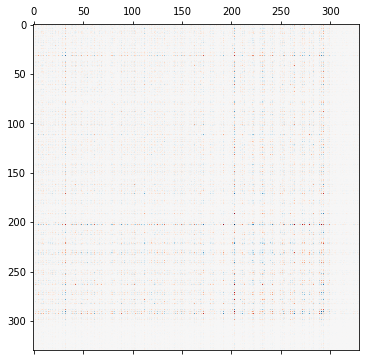

In [96]:
matshow(np.linalg.inv(collected_gradients.T @ collected_gradients))